# Example of using InfoBax with different acquisition functions

This notebook provides an example of how InfoBax with various acquisition functions deals with estimating the shortest path between two vertices in grid-shaped graph. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import gpflow
from bax.utils import graph_initialization
from bax.infoBax import procedure
from bax.utils.compare_module import get_statistics, get_plot
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Hyperparameters for GP
gp_params = {
    'noise': 0.01,
    'kernel': gpflow.kernels.Matern52(variance=3, 
                                      lengthscales=0.3)
}

# Initializing graph 
graph = graph_initialization.MakeGrid2d()

# Alternitavely, you can use this code to create grid-shaped graph:
# graph = graph_initialization.GraphProcessing(make_grid = True)
# graph.create_graph()

# File path where you want to save image/images
file_path = 'images/'

The procedure object has this argumets (in due order):
 - budget (number of iterations of InfoBax), 
 - num_samples (number of samples from predictive distribution for Monte Carlo estimate),
 - start (vertex from where to start),
 - finish (the goal vertex),
 - graph,
 - gp_params (in case we define GP on R^n it should include kernel from gpflow.kernels and noise in observations),
 - init = 1 (initial number of points in our dataset chosen randomly)
 - is_gp_on_graph = False (define GP on R^n)

In [3]:
bax = procedure(budget=120, num_samples=30, start=380, 
                finish=399, graph=graph, gp_params=gp_params, 
                init=1, is_gp_on_graph=False)

Now you can run the procedure with desired acquisition function from ['EIG', 'Random', 'Var']. Parameter ***visualize*** = True (default = False) is only for getting an image for a grid-shaped graph, ***is_one_image*** = True (default = False) is when you want to get the image from the last iteration of InfoBAX, otherwise you get ***budget*** images that can be then visualized. All images will be saved in ***file_path*** with names *image_Bax_{iteration}*/*image_Bax depending* on parameter ***is_one_image***.

In [4]:
bax.run('EIG', num=len(bax.edges), visualize=True, file_path=file_path)

Run the cell below if parameter ***is_one_image*** = True

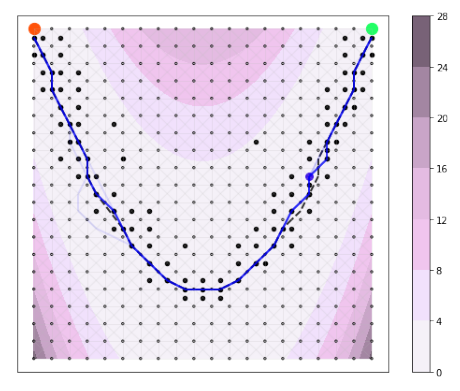

In [5]:
image = plt.imread(file_path + 'image_Bax.png')
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(image)

Run the cell below if parameter ***is_one_image*** = False (default)

In [6]:
def explore_result(step):
    image = plt.imread(file_path + f'image_Bax_{step}.png')
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(image);
    return step

interact(explore_result, step = (0, bax.budget - 1))

interactive(children=(IntSlider(value=59, description='step', max=119), Output()), _dom_classes=('widget-inter…

<function __main__.explore_result(step)>

Now let's compare three acquisition functions. ***num_trials*** is the number of experiments you want to have in order to get more reliable results. To compare functions, set parameter ***compare_strategies*** to True (default is False), and give path to the folder where to save all needed statistics (which are the first, second and third quantiles of the estimated path's cost).

In [7]:
num_trials = 50
for i in range(num_trials):
    bax_1 = procedure(budget=120, num_samples=30, start=380, 
                    finish=399, graph=graph, gp_params=gp_params, 
                    init=1, is_gp_on_graph=False)
    bax_1.run('EIG', num=len(bax.edges), 
              compare_strategies=True, file_path='data/')

    bax_2 = procedure(budget=120, num_samples=30, start=380, 
                      finish=399, graph=graph, gp_params=gp_params, 
                      init=1, is_gp_on_graph=False)
    bax_2.run('Random', num=len(bax.edges), 
              compare_strategies=True, file_path='data/')

    bax_3 = procedure(budget=120, num_samples=30, start=380, 
                      finish=399, graph=graph, gp_params=gp_params, 
                      init=1, is_gp_on_graph=False)
    bax_3.run('Var', num=len(bax.edges), 
              compare_strategies=True, file_path='data/')

Now in the folder you have three files for different acquisition functions, each containing ***num_trials*** times ***bax_i.budget*** lines. In order to get statistics for visualisation based on all that information you need to use a ***get_statistics*** procedure. For further information about arguments of the procedure please go to bax/utils/compare_module.

In [8]:
params = {
    'Matern52': 'EIG.txt',
    'Random_Matern52': 'Random.txt',
    'Var_Matern52': 'Var.txt'
}

get_statistics(dict_of_file_names=params, path_to_dir='data/', 
               num_of_iter=bax.budget, num_of_trials=num_trials)

The last step is to get a plot where the result of infoBAX with different acquisition functions will be visualized. For such a purpose a ***get_plot*** procedure from bax/utils/compare_module is used.

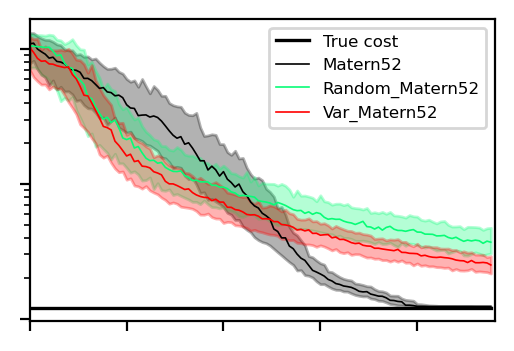

In [9]:
params = {
    'Matern52': 'black',
    'Random_Matern52': '#08FC77',
    'Var_Matern52': 'red'
}

paint_params = {
    'figsize': (3, 2),
    'dpi': 200,
    'linewidth': 0.6,
    'title': None,
    'loc': 1,
    'fontsize': 6,
    'scale': 'semilogy',
    'name': 'comparison'
}
get_plot('data/', params, paint_params, 
         np.sum(bax.true_val), bax.budget)